TODO List:
- Try normalizing all samples to use coordinates relative to an origin at the centroid of the 3 participating hotspots for that sample
- Try clustering or creating binned "zones" for lat/long that are directly predicted like tokens

In [118]:
import numpy as np
import random
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
import pandas as pd
from typing import List, Tuple
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# Helper Functions

In [119]:
# Assuming normalized lat/long contains values in range -1:1... return de-normalized values as true lat/long
def denorm_lat_long(normalized_lat_long):
    lat_long = (normalized_lat_long + 1.0) / 2.0
    lat_long[:, 0] *= 180.0
    lat_long[:, 0] -= 90.0
    lat_long[:, 1] *= 360.0
    lat_long[:, 1] -= 180.0
    return lat_long
    
    
# approximates the earth's surface as a sphere
# converts the (lat, long) to (x, y, z) coordinates in normalized 3d space (range -1:1)
#   z=-1 is the south pole
#   z=1 is the north pole
#   x=1 and x=-1 are the prime meridian, and the dateline,
#   y=1 and y=-1 are 90 degrees East and 90 degrees West
def convert_lat_long_to_cart_xyz(lat_long_deg):
    lat = np.radians(lat_long_deg[:,0])
    lon = np.radians(lat_long_deg[:,1])
    return np.stack([
            np.sin(np.pi / 2.0 - lat) * np.cos(lon),
            np.sin(np.pi / 2.0 - lat) * np.sin(lon),
            np.cos(np.pi / 2.0 - lat)
    ]).T

def convert_lat_long_to_cart_xyz_TORCH(lat_long_deg: Tensor)->Tensor:
    lat = torch.deg2rad(lat_long_deg[:,0])
    lon = torch.deg2rad(lat_long_deg[:,1])
    return torch.stack([
        torch.sin(np.pi / 2.0 - lat) * torch.cos(lon), # x
        torch.sin(np.pi / 2.0 - lat) * torch.sin(lon), # y
        torch.cos(np.pi / 2.0 - lat)                   # z
    ]).T


def haversine_np(lat_long_deg_1, lat_long_deg_2, radius:float=1.0):
    """
    Calculate the great circle distance between two points on a sphere
    ie: Shortest distance between two points on the surface of a sphere
    """
    lat_1, lon_1, lat_2, lon_2 = map(np.deg2rad, [lat_long_deg_1[:,0], lat_long_deg_1[:,1], lat_long_deg_2[:,0], lat_long_deg_2[:,1]])
    d = np.sin((lat_2 - lat_1)/2)**2 + np.cos(lat_1)*np.cos(lat_2) * np.sin((lon_2 - lon_1)/2)**2
    arc_len = 2 * radius * np.arcsin(np.sqrt(d))
    return arc_len
    
def haversine_torch(lat_long_deg_1:Tensor, lat_long_deg_2:Tensor, radius:float=1.0)->Tensor:
    """
    Calculate the great circle distance between two points on a sphere
    ie: Shortest distance between two points on the surface of a sphere
    """
    lat_1, lon_1, lat_2, lon_2 = map(torch.deg2rad, [lat_long_deg_1[:,0], lat_long_deg_1[:,1], lat_long_deg_2[:,0], lat_long_deg_2[:,1]])
    d = torch.sin((lat_2 - lat_1)/2)**2 + torch.cos(lat_1)*torch.cos(lat_2) * torch.sin((lon_2 - lon_1)/2)**2
    arc_len = 2 * radius * torch.arcsin(torch.sqrt(d))
    return arc_len


def equirectangular_np(lat_long_deg_1, lat_long_deg_2, radius:float=1.0):
    """
    Simplified version of haversine for small distances where 
    Pythagoras theorem can be used on an equirectangular projection
    """
    lat_1, lon_1, lat_2, lon_2 = map(np.deg2rad, [lat_long_deg_1[:,0], lat_long_deg_1[:,1], lat_long_deg_2[:,0], lat_long_deg_2[:,1]])
    x = (lon_2 - lon_1) * np.cos(0.5 * (lat_2 + lat_1))
    y = lat_2 - lat_1
    return radius * np.sqrt(x*x + y*y)
    
def equirectangular_torch(lat_long_deg_1:Tensor, lat_long_deg_2:Tensor, radius:float=1.0)->Tensor:
    """
    Simplified version of haversine for small distances where 
    Pythagoras theorem can be used on an equirectangular projection
    """
    lat_1, lon_1, lat_2, lon_2 = map(torch.deg2rad, [lat_long_deg_1[:,0], lat_long_deg_1[:,1], lat_long_deg_2[:,0], lat_long_deg_2[:,1]])
    x = (lon_2 - lon_1) * torch.cos(0.5 * (lat_2 + lat_1))
    y = lat_2 - lat_1
    return radius * torch.sqrt(x*x + y*y)

In [120]:
def _test_haversine():
    R = 6373.0 # radius of the earth in km
    ll_a, ll_b = np.array([[45.7597, 4.8422]]), np.array([[48.8567, 2.3508]])
    l = haversine_np(ll_a, ll_b, radius=1.0)
    l_earth = haversine_np(ll_a, ll_b, radius=R)
    print(f"Arc_len: {l[0]:.2f} norm (unit sphere), {l_earth[0]:.2f} km (earth)")

    ll_a, ll_b = torch.tensor(ll_a), torch.tensor(ll_b)
    l = haversine_torch(ll_a, ll_b, radius=1.0)
    l_earth = haversine_torch(ll_a, ll_b, radius=R)
    print(f"Arc_len: {l.item():.2f} norm (unit sphere), {l_earth.item():.2f} km (earth)")

def _test_cart_conversion():
    norm = np.random.randn(1000, 2) * 2.0 -1.0
    xyz = convert_lat_long_to_cart_xyz(denorm_lat_long(norm))
    xyz_TORCH = convert_lat_long_to_cart_xyz_TORCH(denorm_lat_long(torch.tensor(norm)))
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2])
    ax.set_title("Numpy")
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(xyz_TORCH[:,0], xyz_TORCH[:,1], xyz_TORCH[:,2])
    ax2.set_title("PyTorch")
    plt.show()

def _test_equirectangular():
    R = 6373.0 # radius of the earth in km
    ll_a, ll_b = np.array([[45.7597, 4.8422]]), np.array([[48.8567, 2.3508]])
    l = equirectangular_np(ll_a, ll_b, radius=1.0)
    l_earth = equirectangular_np(ll_a, ll_b, radius=R)
    print(f"Arc_len: {l[0]:.2f} norm (unit sphere), {l_earth[0]:.2f} km (earth)")

    ll_a, ll_b = torch.tensor(ll_a), torch.tensor(ll_b)
    l = equirectangular_torch(ll_a, ll_b, radius=1.0)
    l_earth = equirectangular_torch(ll_a, ll_b, radius=R)
    print(f"Arc_len: {l.item():.2f} norm (unit sphere), {l_earth.item():.2f} km (earth)")

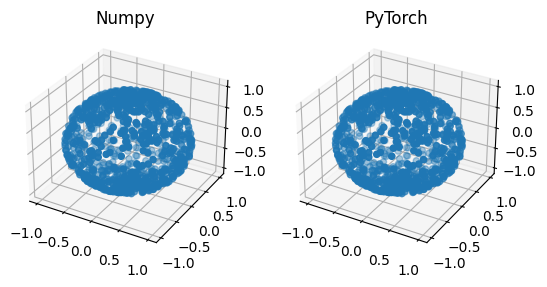

Arc_len: 0.06 norm (unit sphere), 392.34 km (earth)
Arc_len: 0.06 norm (unit sphere), 392.34 km (earth)
Arc_len: 0.06 norm (unit sphere), 392.39 km (earth)
Arc_len: 0.06 norm (unit sphere), 392.39 km (earth)


In [121]:
_test_cart_conversion()
_test_haversine()
_test_equirectangular()

# Data

In [122]:
data = pd.read_csv("data/mappers.csv")
data = data.drop(["id"], axis=1)

In [123]:
data.shape

(7276109, 16)

In [124]:
data.head()

,latitude,longitude,frequency,spreading_factor,hotspot1_lat,hotspot1_long,hotspot1_rssi,hotspot1_snr,hotspot2_lat,hotspot2_long,hotspot2_rssi,hotspot2_snr,hotspot3_lat,hotspot3_long,hotspot3_rssi,hotspot3_snr
0,44.305403,-96.806407,904.099976,SF7BW125,44.304234,-96.780698,-117.0,-2.8,44.320588,-96.912926,-117.0,-5.2,44.293880,-96.812899,-118.0,-4.000000
1,50.720951,-1.876882,868.299988,SF10BW125,50.715620,-1.883604,-112.0,-12.0,50.725903,-1.865836,-117.0,-11.8,50.721518,-1.874929,-120.0,-16.200001
2,36.144499,-86.792449,904.299988,SF9BW125,36.152221,-86.791273,-85.0,7.2,36.196064,-86.850049,-102.0,2.5,36.150951,-86.792024,-102.0,-0.200000
3,33.228809,-117.011214,904.299988,SF7BW125,33.302632,-116.852721,-100.0,4.8,33.252398,-117.004042,-103.0,4.8,33.094660,-116.581460,-122.0,-9.200000
4,36.146766,-86.795201,904.299988,SF9BW125,36.196064,-86.850049,-106.0,0.2,36.152345,-86.790965,-111.0,-4.8,36.143980,-86.789434,-112.0,1.200000


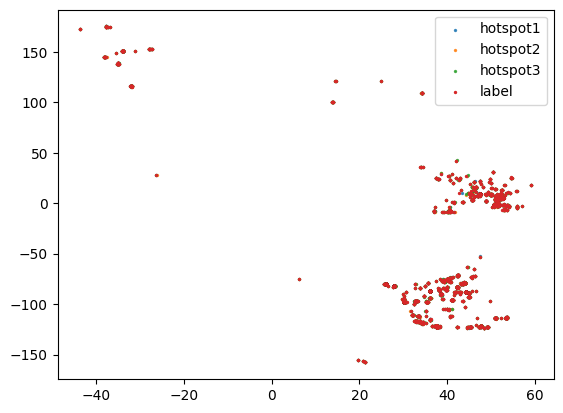

In [125]:
# Visualize some samples
subset = data.sample(n=2500)
for i in range(1,4):
    plt.scatter(subset[f"hotspot{i}_lat"], subset[f"hotspot{i}_long"], s=2, alpha=0.8, label=f"hotspot{i}")
plt.scatter(subset["latitude"], subset["longitude"], s=2, label="label")
plt.legend()

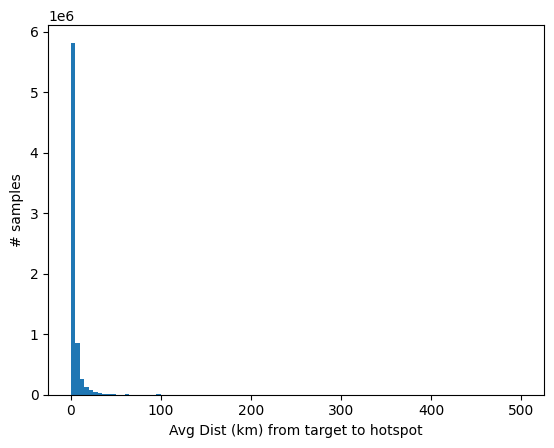

In [126]:
# For each sample, calculate an average haversine distance between the target and the hotspots in that sample
ll_target = data[["latitude", "longitude"]].to_numpy()
ll_hs1, ll_hs2, ll_hs3 = [
    data[[f"hotspot{i}_lat", f"hotspot{i}_long"]].to_numpy()
    for hs_idx in range(1, 4)
]
r_earth = 6373.0 # radius of the earth in km
dist_to_hs_km = np.stack([haversine_np(ll_target, ll_hs, radius=r_earth) for ll_hs in (ll_hs1, ll_hs2, ll_hs3)],1)
avg_dist_to_hs_km = dist_to_hs_km.mean(axis=1)

data["avg_hav_dist_2_hs_km"] = avg_dist_to_hs_km

plt.hist(data["avg_hav_dist_2_hs_km"], bins=100)
plt.ylabel("# samples")
plt.xlabel("Avg Dist (km) from target to hotspot")
plt.show()

In [127]:
for q in [0.5, 0.9, 0.99, 0.995, 0.999, 0.9999]:
    km = np.quantile(data["avg_hav_dist_2_hs_km"], q)
    print(f"@ q={q},\t km={km:.2f}km")

@ q=0.5,	 km=1.65km
@ q=0.9,	 km=8.44km
@ q=0.99,	 km=33.31km
@ q=0.995,	 km=55.26km
@ q=0.999,	 km=97.52km
@ q=0.9999,	 km=423.68km


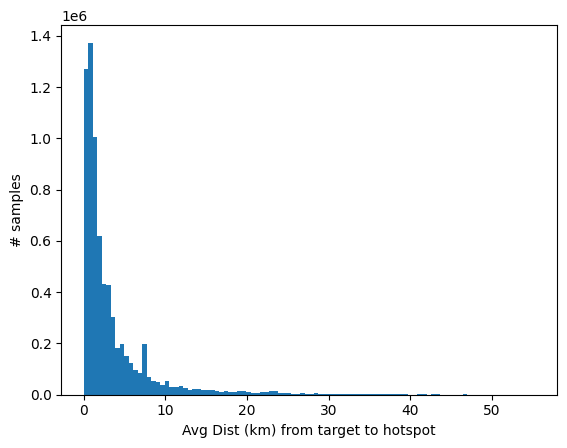

In [128]:
# filter data by REMOVING outliers that represent EXTREMELY distant targets
q = 0.995
threshold_km = np.quantile(data["avg_hav_dist_2_hs_km"], q)
data = data[data["avg_hav_dist_2_hs_km"] <= threshold_km]
after = data.pop("avg_hav_dist_2_hs_km")
plt.hist(after, bins=100)
plt.ylabel("# samples")
plt.xlabel("Avg Dist (km) from target to hotspot")
plt.show()

In [129]:
# Convert categorical spreading factors to one-hot
sf_original = data.pop("spreading_factor")
data = pd.concat([data, sf_original.str.get_dummies()], axis=1)
data.head()

,latitude,longitude,frequency,hotspot1_lat,hotspot1_long,hotspot1_rssi,hotspot1_snr,hotspot2_lat,hotspot2_long,hotspot2_rssi,...,hotspot3_rssi,hotspot3_snr,SF10BW125,SF11BW125,SF12BW125,SF7BW125,SF7BW250,SF8BW125,SF8BW500,SF9BW125
0,44.305403,-96.806407,904.099976,44.304234,-96.780698,-117.0,-2.8,44.320588,-96.912926,-117.0,...,-118.0,-4.000000,0,0,0,1,0,0,0,0
1,50.720951,-1.876882,868.299988,50.715620,-1.883604,-112.0,-12.0,50.725903,-1.865836,-117.0,...,-120.0,-16.200001,1,0,0,0,0,0,0,0
2,36.144499,-86.792449,904.299988,36.152221,-86.791273,-85.0,7.2,36.196064,-86.850049,-102.0,...,-102.0,-0.200000,0,0,0,0,0,0,0,1
3,33.228809,-117.011214,904.299988,33.302632,-116.852721,-100.0,4.8,33.252398,-117.004042,-103.0,...,-122.0,-9.200000,0,0,0,1,0,0,0,0
4,36.146766,-86.795201,904.299988,36.196064,-86.850049,-106.0,0.2,36.152345,-86.790965,-111.0,...,-112.0,1.200000,0,0,0,0,0,0,0,1


In [130]:
# Normalize lat/long labels to range -1:1
data["latitude"] = 1 - 2* (data["latitude"] + 90.0) / 180.0
data["longitude"] = 1 - 2* (data["longitude"] + 180.0) / 360.0

In [131]:
# Split the data into train and test with 80 train / 20 test
data_train, data_val = train_test_split(data, test_size=0.2, random_state = 1)

In [132]:
# Extract the labels (latitude and longitude)
y_train = data_train[['latitude', 'longitude']].to_numpy()
y_val = data_val[['latitude', 'longitude']].to_numpy()
print(y_train.shape, y_train.min(), y_train.max())
print(y_val.shape, y_val.min(), y_val.max())

(5791789, 2) -0.9758313863472121 0.8860121607476376
(1447948, 2) -0.9756849907100944 0.8860623349414842


In [133]:
# Extract the samples (data features, without labels)
x_train = np.array(data_train.drop(["latitude", "longitude"], axis=1))
x_val = np.array(data_val.drop(["latitude", "longitude"], axis=1))

# Normalize all features to expected range -1:1 based on consideration of the training data alone
X_TRAIN_MIN = x_train.min(axis=0)
X_TRAIN_RANGE = x_train.ptp(axis=0)

x_train = 1 - 2 * (x_train - X_TRAIN_MIN) / X_TRAIN_RANGE
x_val = 1 - 2 * (x_val - X_TRAIN_MIN) / X_TRAIN_RANGE

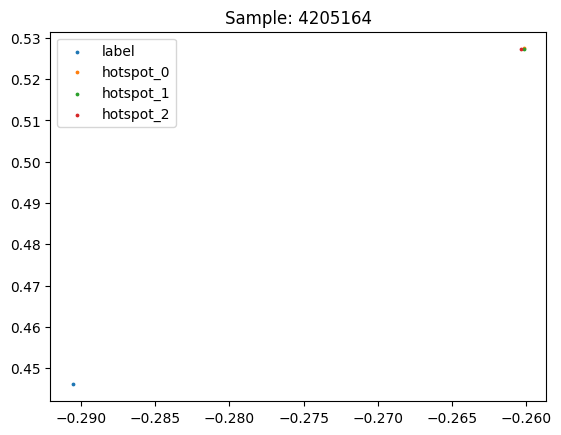

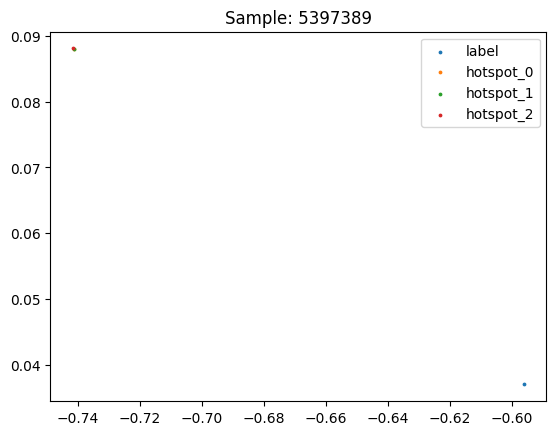

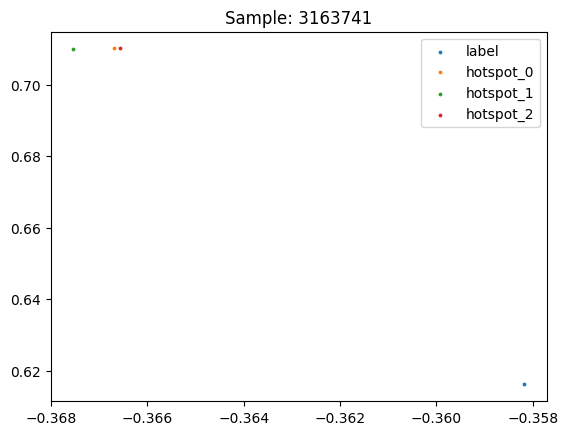

In [134]:
# Visualize a few samples and labels
for _ in range(3):
    sample_idx = np.random.randint(0, y_train.shape[0])
    plt.figure()
    plt.scatter(y_train[sample_idx,0], y_train[sample_idx,1], s=3, label="label")
    for hs_idx, (x_idx, y_idx) in enumerate([(1,2), (5,6), (9,10)]):
        plt.scatter(x_train[sample_idx,x_idx], x_train[sample_idx,y_idx], s=3, label=f"hotspot_{hs_idx}")
    plt.legend()
    plt.title(f"Sample: {sample_idx}")

In [135]:
RANDOM_SEED = 42
N_DIMENSIONS = y_train.shape[-1]
N_CHANNELS = x_train.shape[-1]

In [136]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [137]:
torch.manual_seed(RANDOM_SEED)

Xtr, Ytr = torch.tensor(x_train).float().to(device), torch.tensor(y_train).float().to(device)
Xval, Yval = torch.tensor(x_val).float().to(device), torch.tensor(y_val).float().to(device)

def get_batch(batch_size:int =32, is_train: bool=True):
    # generate a small batch of data of inputs x and targets y
    src_data = Xtr if is_train else Xval
    labels = Ytr if is_train else Yval
    ix = torch.randint(0, src_data.shape[0], (batch_size,))
    return src_data[ix], labels[ix]

# Loss Functions

Geometric distances between lat/long are NOT linear across the range of lat/long.... so use other coordinates or distance metrics when calculating loss


In [138]:
def cartesian_loss_func(pred_norm_lat_long: Tensor, labels_norm_lat_long: Tensor)->Tensor:
    # Convert norm lat/long to cart xyz
    pred_xyz = convert_lat_long_to_cart_xyz_TORCH(denorm_lat_long(pred_norm_lat_long))
    labels_xyz = convert_lat_long_to_cart_xyz_TORCH(denorm_lat_long(labels_norm_lat_long))
    return F.mse_loss(pred_xyz, labels_xyz)

def haversine_loss_func(pred_norm_lat_long: Tensor, labels_norm_lat_long: Tensor)->Tensor:
    dist = haversine_torch(denorm_lat_long(pred_norm_lat_long), denorm_lat_long(labels_norm_lat_long))
    # square to penalize larger errors more significantly
    sq_dist = dist ** 2 
    return torch.mean(sq_dist)

def equirectangular_loss_func(pred_norm_lat_long: Tensor, labels_norm_lat_long: Tensor)->Tensor:
    dist = equirectangular_torch(denorm_lat_long(pred_norm_lat_long), denorm_lat_long(labels_norm_lat_long))
    # square to penalize larger errors more significantly
    sq_dist = dist ** 2 
    return torch.mean(sq_dist)

# Model

In [159]:
class MlpTriangulationModel(nn.Module):
    def __init__(
        self, hidden_layer_size: int = 64, n_hidden_layers: int = 5, b_norm: bool = True
    ):
        super().__init__()
        fan_in_out = [
            (N_CHANNELS, hidden_layer_size)
        ] + (n_hidden_layers - 1) * [(hidden_layer_size, hidden_layer_size)]
        layers = [
            # Flatten the data for each node into a single vector like so: [x1,y1,ss1, x2,y2,ss2...]
            nn.Flatten(start_dim=1)
        ]
        for fan_in, fan_out in fan_in_out:
            layers += (
                [nn.Linear(fan_in, fan_out, bias=not b_norm)]
                + ([nn.BatchNorm1d(fan_out)] if b_norm else [])
                + [nn.ReLU()]
            )

        layers.append(nn.Linear(fan_in_out[-1][-1], N_DIMENSIONS))
        # parameter init
        with torch.no_grad():
            layers[-1].weight *= 0.1  # make last layer less confident
        self.layers = nn.Sequential(*layers)

    def forward(self, samples: Tensor, targets: Tensor = None) -> Tuple[Tensor, Tensor]:
        logits = self.layers(samples)
        if targets is None:
            loss = None
        else:
            # loss = haversine_loss_func(pred_norm_lat_long=logits, labels_norm_lat_long=targets)
            # loss = equirectangular_loss_func(pred_norm_lat_long=logits, labels_norm_lat_long=targets)
            # loss = cartesian_loss_func(pred_norm_lat_long=logits, labels_norm_lat_long=targets)
            loss = F.mse_loss(logits, targets)
            # loss = F.l1_loss(logits, targets)
        return logits, loss


In [160]:
# Create model
model = MlpTriangulationModel()
# model = TransformerTriangulationModel()
# model = ImageTriangulationModel()

model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

0.018498 M parameters


# Training

In [161]:
# Training
BATCH_SIZE = 128
MAX_STEPS = 25000
LR_DECAY = [MAX_STEPS//3, 4*MAX_STEPS//5]
PRINT_INTERVAL = MAX_STEPS // 25
stats = []

def evaluate(data:Tensor, labels:Tensor)->Tuple[float, float]:
    with torch.no_grad():
        predictions, _ = model(data)
    r_earth = 6373.0 # radius of the earth in km
    dist_err_km = haversine_torch(
        denorm_lat_long(predictions), 
        denorm_lat_long(labels), 
        radius= 6373.0 # radius of the earth in km
    ).cpu().numpy()
    return dist_err_km.mean(), dist_err_km.std()


model.train()
for i in range(MAX_STEPS):
    # Get a random batch
    Xb, Yb = get_batch(batch_size=BATCH_SIZE, is_train=True)

    # Predict coordinates and evaluate loss
    logits, loss = model(Xb,Yb)
    # Backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if i in LR_DECAY:
        print("Adjusting LR")
        for g in optimizer.param_groups:
            g['lr'] *= 0.1
    step_stats = {
        "step": i,
        "loss": loss.item()
    }
    if i % PRINT_INTERVAL == 0:
        with torch.no_grad():
            val_error_mean, val_error_std = evaluate(data=Xval, labels=Yval)
            step_stats["val_error_dist_km_mean"] = val_error_mean
            step_stats["val_error_dist_km_std"] = val_error_std
        print(f"Step: {i},\t Loss: {loss.item():.6f},\tValErrDist: {val_error_mean:.4f} km (std:: {val_error_std:.4f})")
    stats.append(step_stats)

Step: 0,	 Loss: 0.233680,	ValErrDist: 6384.6846 km (std:: 2977.9336)
Step: 1000,	 Loss: 0.000720,	ValErrDist: 279.5868 km (std:: 125.5433)
Step: 2000,	 Loss: 0.000108,	ValErrDist: 208.0764 km (std:: 98.3786)
Step: 3000,	 Loss: 0.000456,	ValErrDist: 217.3817 km (std:: 127.9536)
Step: 4000,	 Loss: 0.000136,	ValErrDist: 162.7287 km (std:: 133.0689)
Step: 5000,	 Loss: 0.000084,	ValErrDist: 196.4504 km (std:: 124.7025)
Step: 6000,	 Loss: 0.000171,	ValErrDist: 166.2631 km (std:: 203.1294)
Step: 7000,	 Loss: 0.000271,	ValErrDist: 198.0693 km (std:: 126.4802)
Step: 8000,	 Loss: 0.000218,	ValErrDist: 162.9258 km (std:: 125.4060)
Adjusting LR
Step: 9000,	 Loss: 0.000060,	ValErrDist: 82.9062 km (std:: 50.7944)
Step: 10000,	 Loss: 0.000052,	ValErrDist: 92.9320 km (std:: 34.0022)
Step: 11000,	 Loss: 0.000038,	ValErrDist: 72.0940 km (std:: 44.7476)
Step: 12000,	 Loss: 0.000048,	ValErrDist: 79.0153 km (std:: 53.2570)
Step: 13000,	 Loss: 0.000027,	ValErrDist: 69.0369 km (std:: 40.7407)
Step: 14000,	 L

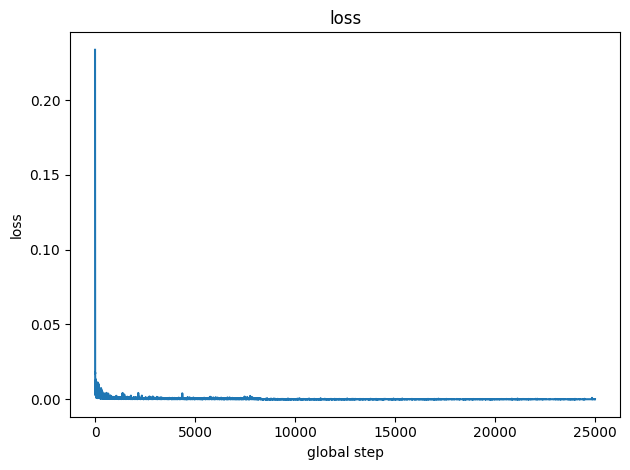

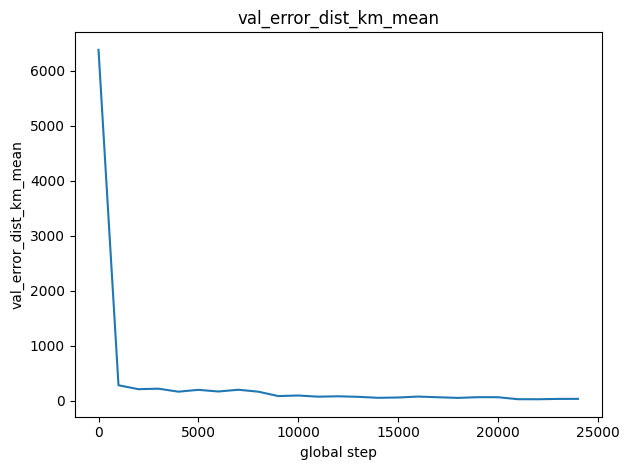

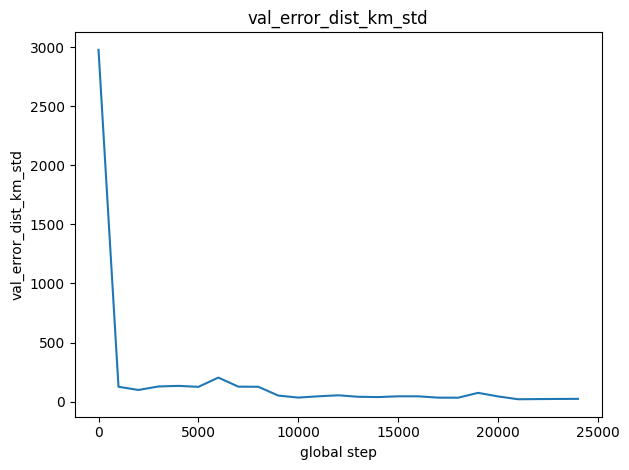

In [162]:
plot_contents = {}
for i, step_stats in enumerate(stats):
    step = step_stats.pop("step", i)
    for k, v in step_stats.items():
        if k not in plot_contents:
            plot_contents[k] = {"x": [], "y":[]}
        plot_contents[k]["x"].append(step)
        plot_contents[k]["y"].append(v)
for k, v in plot_contents.items():
    x, y = np.asarray(v["x"]), np.asarray(v["y"])
    plt.figure()
    plt.title(k)
    plt.plot(x, y)
    plt.xlabel("global step")
    plt.ylabel(k)
    plt.tight_layout()


# Inference

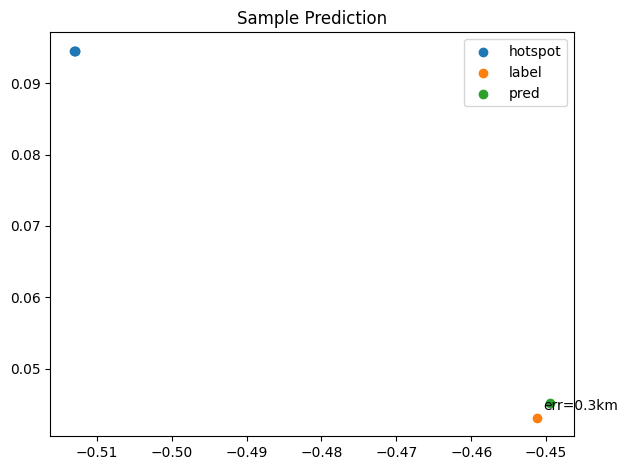

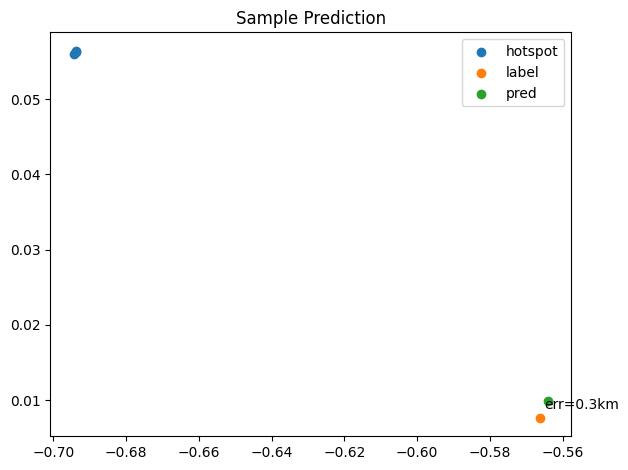

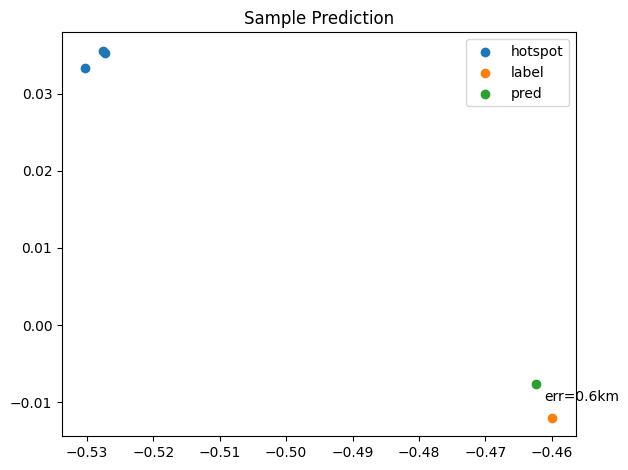

In [163]:
# Predict
samples, labels = get_batch(batch_size=3, is_train=False)
model.eval()
with torch.no_grad():
    predictions, _ = model(samples)
for sample, label, pred in zip(samples.cpu(), labels.cpu(), predictions.cpu()):
    nodes_x = [x for i, x in enumerate(sample) if i in (1,5,9)]
    nodes_y = [x for i, x in enumerate(sample) if i in (2,6,10)]
    dist_err_km = haversine_np(
        np.expand_dims(pred.numpy(),0), 
        np.expand_dims(label.numpy(),0), 
        radius=6373.0
    )[0]
    plt.figure()
    plt.title("Sample Prediction")
    plt.scatter(
        x=nodes_x,
        y=nodes_y,
        label="hotspot",
    )
    plt.scatter(x=label[0], y=label[1], label="label")
    plt.scatter(x=pred[0], y=pred[1], label="pred")
    mid = (label + pred) / 2
    plt.annotate(f"err={dist_err_km:.1f}km", xy=(mid[0], mid[1]))
    plt.tight_layout()
    plt.legend()

In [164]:
# Calculate errors for the entire validation set
model.eval()
with torch.no_grad():
    predictions, _ = model(Xval)
r_earth = 6373.0 # radius of the earth in km
dist_err_km = haversine_torch(
    denorm_lat_long(predictions), 
    denorm_lat_long(Yval), 
    radius= 6373.0 # radius of the earth in km
).cpu().numpy()

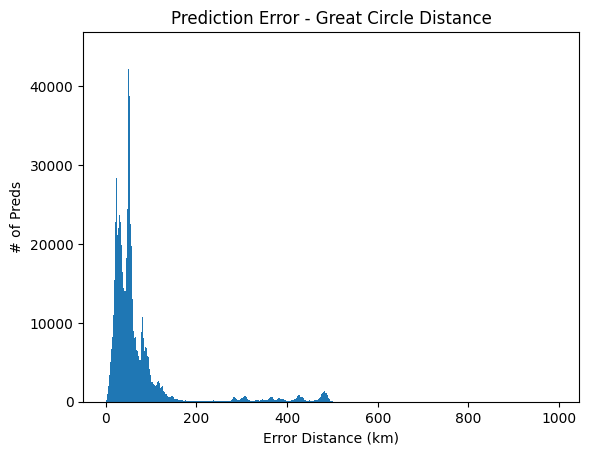

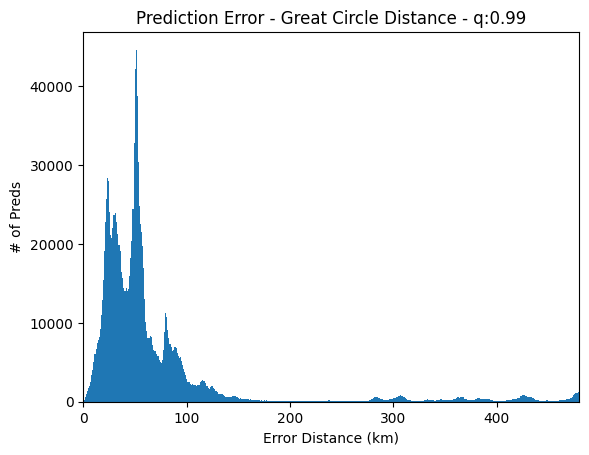

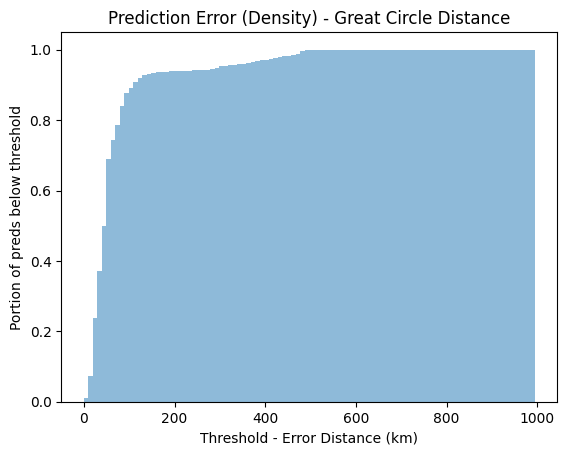

In [165]:
# Look at distribution:
plt.hist(dist_err_km, bins=1000)
plt.title("Prediction Error - Great Circle Distance")
plt.xlabel("Error Distance (km)")
plt.ylabel("# of Preds")
plt.show()

# Zoom in
plt.figure()
plt.hist(dist_err_km, bins=1000)
plt.title("Prediction Error - Great Circle Distance - q:0.99")
plt.xlim(0, np.quantile(dist_err_km, 0.99))
plt.xlabel("Error Distance (km)")
plt.ylabel("# of Preds")
plt.show()

plt.figure()
plt.title("Prediction Error (Density) - Great Circle Distance")
plt.hist(dist_err_km, bins=100, alpha=0.5, density=True, cumulative=True)
plt.xlabel("Threshold - Error Distance (km)")
plt.ylabel("Portion of preds below threshold")
plt.show()